In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.


# np.random.seed(1000)


C:\Users\kmura\AppData\Local\Programs\Python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
inputDim = 10

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]


In [5]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)


# Generator


In [ ]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=inputDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='mse', optimizer=adam)


In [ ]:
generator.summary()

# Discriminator

In [ ]:

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(inputDim + 1, activation='softmax'))
discriminator.compile(loss='categorical_crossentropy', optimizer=adam)

# Combined network


In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(inputDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='categorical_crossentropy', optimizer=adam)


In [8]:
import os
image_folder = 'images_numb_Gan_mse_sftmx_cc_cc'

if not os.path.exists(image_folder):
    os.mkdir(image_folder)

In [9]:
import os
model_folder = 'model_numb_Gan_mse_sftmx_cc_cc'

if not os.path.exists(model_folder):
    os.mkdir(model_folder)

In [ ]:
dLosses = []
gLosses = []


# Plot the loss from each batch


In [ ]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}/dcgan_loss_epoch_%d.png'.format(image_folder) % epoch)


# Create a wall of generated MNIST images


In [ ]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
#     noise = np.random.normal(0, 1, size=[examples, randomDim])
    
    
#     pickup_batch = np.random.randint(0, X_test.shape[0], size=examples)
    
    pickup_batch = np.arange(0,examples) 

    our_input = to_categorical(y_test[pickup_batch],inputDim)
    
    generatedImages = generator.predict(our_input)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/dcgan_generated_image_epoch_%d.png'.format(image_folder) % epoch)


# Save the generator and discriminator networks (and weights) for later use


In [6]:
from keras.utils.np_utils import to_categorical

In [ ]:
def saveModels(epoch):
    generator.save('{}/dcgan_generator_epoch_%d.h5'.format(model_folder) % epoch)
    discriminator.save('{}/dcgan_discriminator_epoch_%d.h5'.format(model_folder) % epoch)


In [ ]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):
            # Get a random set of input noise and images

            
            
            pickup_batch = np.random.randint(0, X_train.shape[0], size=batchSize)

            our_input = to_categorical(y_train[pickup_batch],inputDim)
            
            
            imageBatch = X_train[pickup_batch]

            # Generate fake MNIST images
            generatedImages = generator.predict(our_input)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
#             yDis = np.zeros(2*batchSize)
            
            image_outputs = to_categorical(y_train[pickup_batch],inputDim+1)
            gen_image_outputs = to_categorical([inputDim]*batchSize,inputDim+1)  # 10 means 11. 11 means fake.
            yDis = np.vstack((image_outputs,gen_image_outputs))
            
            
            
#             # One-sided label smoothing
#             yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
#             noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            our_input = to_categorical(y_train[pickup_batch],inputDim)
    
            yGen = to_categorical(y_train[pickup_batch],inputDim+1)


            discriminator.trainable = False
            gloss = gan.train_on_batch(our_input, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 3 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)



In [ ]:
if __name__ == '__main__':
    train(15, 128)

In [ ]:
# if __name__ == '__main__':
#     train(75, 128)

In [15]:
from keras.models import load_model
discriminator=load_model('{}/dcgan_discriminator_epoch_12.h5'.format(model_folder))

C:\Users\kmura\AppData\Local\Programs\Python\Python35\lib\site-packages\keras\models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [18]:
%matplotlib inline

# import matplotlib
# import numpy as np
# import matplotlib.pyplot as plt

In [12]:
from keras.models import load_model
generator=load_model('{}/dcgan_generator_epoch_9.h5'.format(model_folder))

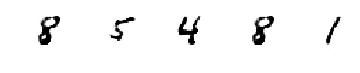

In [14]:
generatedImages = generator.predict(to_categorical(np.array([8,5,4,8,1]),inputDim))
dim=(28,28)

# plt.imshow(generatedImages[0, 0], interpolation='nearest', cmap='gray_r')
## To plot ###
dim=(10, 10)
figsize=(10, 10)

plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
    
plt.tight_layout()
plt.show()



In [ ]:
# generatedImages.shape